In [1]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/oral-cancer-dataset
/kaggle/input/oral-cancer-dataset/Oral Cancer
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/NON CANCER
/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0
/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new
/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER
/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER


In [3]:
dataset_path = "/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new"
import os
os.listdir(dataset_path)


['CANCER', 'NON CANCER']

In [4]:
classes = os.listdir(dataset_path)
classes

['CANCER', 'NON CANCER']

In [5]:
class_counts = {}

for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(class_folder))

class_counts


{'CANCER': 500, 'NON CANCER': 450}

### Sample Data

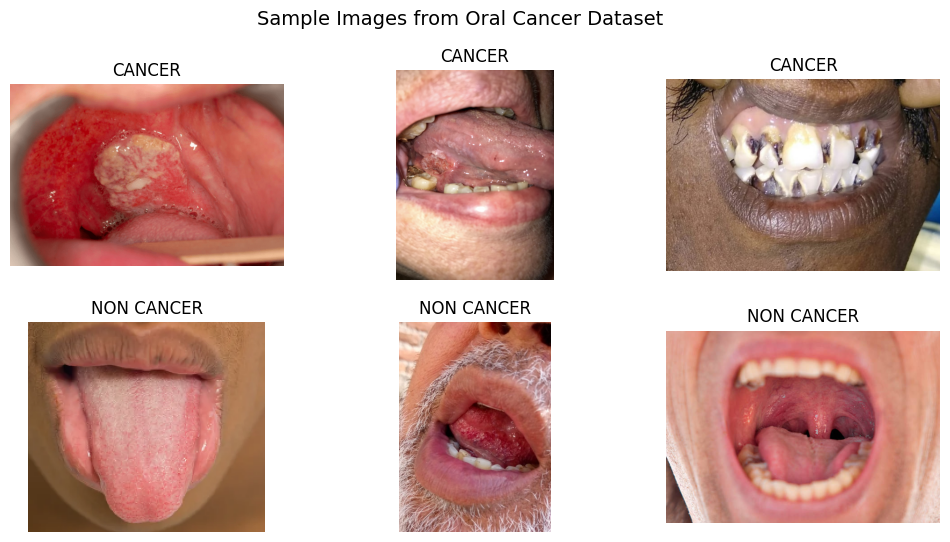

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

classes = ['CANCER', 'NON CANCER']
samples_per_class = 3

plt.figure(figsize=(12, 6))

img_index = 1

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    img_names = random.sample(os.listdir(class_path), samples_per_class)

    for img_name in img_names:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(len(classes), samples_per_class, img_index)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

        img_index += 1

plt.suptitle("Sample Images from Oral Cancer Dataset", fontsize=14)
plt.show()

# **Data Cleaning**

## count problematic images.

In [7]:
from PIL import Image

bad_images = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()  # verify image integrity
        except:
            bad_images.append(img_path)

len(bad_images)


0

## Check Image Dimensions

In [8]:
from PIL import Image
import os
import random

sample_sizes = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path)
    sample_sizes.append((cls, img.size))

sample_sizes

[('CANCER', (1426, 1796)), ('NON CANCER', (800, 800))]

## Resize(224×224) + Normalize Images

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

2026-01-28 16:02:09.947951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769616130.192974     111 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769616130.272409     111 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769616130.825504     111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769616130.825552     111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769616130.825555     111 computation_placer.cc:177] computation placer alr

### Image Preprocessing

To ensure uniform input to the deep learning model, image preprocessing was performed using an ImageDataGenerator. All images were rescaled by a factor of 1/255 to normalize pixel values to the range [0, 1]. This normalization helps improve numerical stability and speeds up model convergence during training. Preprocessing was applied on-the-fly without altering the original dataset.


## Create Training & Validation Generators

### Training Generator

In [10]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

Found 760 images belonging to 2 classes.


### Validation Generator

In [11]:
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)

Found 190 images belonging to 2 classes.


### Data Preparation Summary

The dataset was preprocessed using on-the-fly image resizing and normalization. An 80:20 training–validation split was applied, resulting in 760 images for training and 190 images for validation. Binary class labels were used for oral cancer classification.


### Data Augmentation Generator

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

### Recreate Training Generator

In [13]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

Found 760 images belonging to 2 classes.


### Data Augmentation

To address the limited dataset size and presence of duplicate images, data augmentation techniques such as rotation, zooming, horizontal flipping, and brightness adjustment were applied to the training data. This helps improve model generalization and reduces overfitting.


# **1 MobileNetV2 Model**

In [14]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

I0000 00:00:1769616213.648968     111 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769616213.653042     111 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Base Model Selection

MobileNetV2 pretrained on ImageNet was selected as the base model. The top classification layers were removed, and the pretrained layers were frozen to preserve learned features and reduce overfitting on the small oral cancer dataset.


### Add Custom Classification Layers

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

### Custom Classification Head

A custom classification head was added on top of the pretrained base model. Global average pooling was used to reduce dimensionality, followed by fully connected layers with dropout regularization to minimize overfitting. A sigmoid activation function was used for binary classification.


### Compile the Model

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### add callbacks

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


### ModelCheckpoint

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    '/kaggle/working/oral_cancer_mobilenetv2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Training Callbacks

Early stopping was applied to prevent overfitting by monitoring validation loss. Model checkpointing was used to save the best-performing model during training, ensuring reliable deployment and reproducibility.


# **Training Model**

In [22]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9204 - loss: 0.2073
Epoch 1: val_loss improved from inf to 0.24682, saving model to /kaggle/working/oral_cancer_mobilenetv2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.9204 - loss: 0.2072 - val_accuracy: 0.8895 - val_loss: 0.2468
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9128 - loss: 0.1872
Epoch 2: val_loss did not improve from 0.24682
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.9132 - loss: 0.1867 - val_accuracy: 0.8737 - val_loss: 0.2799
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9455 - loss: 0.1510
Epoch 3: val_loss did not improve from 0.24682
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 322ms/step - accuracy: 0.9453 - loss: 0.1512 - val_accuracy: 0.8895 - val_loss: 0.2681
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9511 - loss: 0.1289
Epoch 4: val_loss improved from 0.24682 to 0.21251, saving model to /kaggle/working/oral_cancer_mobilenetv2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.9511 - loss: 0.1289 - val_accuracy: 0.9053 - val_loss: 0.2125
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9372 - loss: 0.1638
Epoch 5: val_loss improved from 0.21251 to 0.20260, saving model to /kaggle/working/oral_cancer_mobilenetv2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.9373 - loss: 0.1636 - val_accuracy: 0.9211 - val_loss: 0.2026
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9503 - loss: 0.1207
Epoch 6: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.9503 - loss: 0.1205 - val_accuracy: 0.8895 - val_loss: 0.2460
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9482 - loss: 0.1396
Epoch 7: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9483 - loss: 0.1393 - val_accuracy: 0.8526 - val_loss: 0.3169
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9428 - loss: 0.1335
Epoch 8: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - accuracy: 0.9429 - loss: 0.1333 - val_accuracy: 0.8947 - val_loss: 0.2392
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9546 - loss: 0.1206
Epoch 9: val_loss did not improve from 0.20

In [23]:
os.listdir('/kaggle/working')

['.virtual_documents', 'oral_cancer_mobilenetv2.h5']

In [24]:
type(history)

keras.src.callbacks.history.History

# **Visualization** 

## Training vs Validation Accuracy

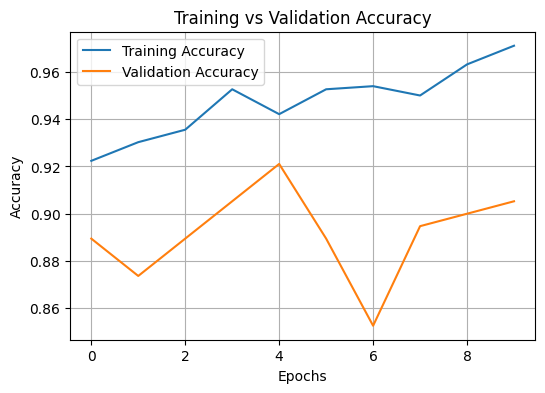

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Training vs Validation Loss

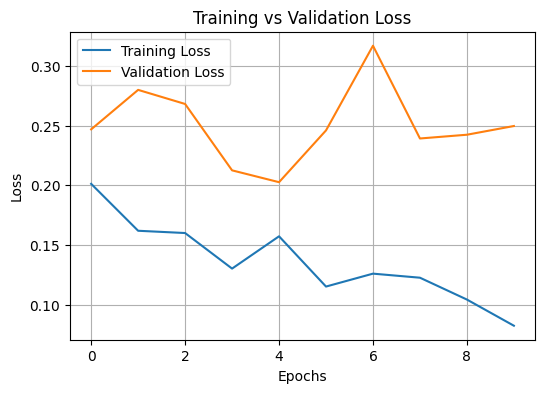

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# **MODEL EVALUATION**

## Get Predictions

In [29]:
import numpy as np

val_generator.reset()     # reset generator 
y_pred_prob = model.predict(val_generator)

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step


In [30]:
# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

y_true = val_generator.classes

In [32]:
print("Predicted labels shape:", y_pred.shape)
print("True labels shape:", y_true.shape)

Predicted labels shape: (190,)
True labels shape: (190,)


## Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[51, 49],
       [50, 40]])

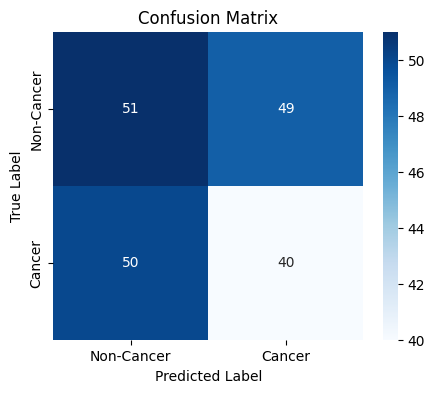

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cancer', 'Cancer'],
            yticklabels=['Non-Cancer', 'Cancer'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Classification Report

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Non-Cancer', 'Cancer']))

              precision    recall  f1-score   support

  Non-Cancer       0.50      0.51      0.51       100
      Cancer       0.45      0.44      0.45        90

    accuracy                           0.48       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.48      0.48      0.48       190



# Threshold Tuning 

In [36]:
new_threshold = 0.35
y_pred_tuned = (y_pred_prob > new_threshold).astype(int).ravel()

## Confusion Matrix for Tuned Model

In [37]:
from sklearn.metrics import confusion_matrix

cm_tuned = confusion_matrix(y_true, y_pred_tuned)
cm_tuned

array([[49, 51],
       [47, 43]])

## Classification Report (Tuned)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_tuned, target_names=['Non-Cancer', 'Cancer']))

              precision    recall  f1-score   support

  Non-Cancer       0.51      0.49      0.50       100
      Cancer       0.46      0.48      0.47        90

    accuracy                           0.48       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.49      0.48      0.48       190



# CLASS WEIGHTS

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# True labels from training generator
train_labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


{0: np.float64(0.95), 1: np.float64(1.0555555555555556)}

## Retrain Model WITH Class Weights

In [40]:
history_cw = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9597 - loss: 0.1176

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - accuracy: 0.9597 - loss: 0.1175 - val_accuracy: 0.9105 - val_loss: 0.2370
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9565 - loss: 0.1024
Epoch 2: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.9563 - loss: 0.1028 - val_accuracy: 0.9000 - val_loss: 0.2834
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9543 - loss: 0.1237
Epoch 3: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.9544 - loss: 0.1235 - val_accuracy: 0.9105 - val_loss: 0.2186
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9745 - loss: 0.0805
Epoch 4: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - accuracy: 0.9743 - loss: 0.0808 - val_accuracy: 0.9053 - val_loss: 0.2397
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9545 - loss: 0.

In [41]:
os.listdir('/kaggle/working')

['.virtual_documents', 'oral_cancer_mobilenetv2.h5']

# **EVALUATION - CLASS-WEIGHT MODEL** 

In [42]:
val_generator.reset()
y_pred_prob_cw = model.predict(val_generator)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


## Convert Probabilities to Labels (with 0.5 threshold)

In [45]:
# Default threshold = 0.5
y_pred_cw = (y_pred_prob_cw > 0.35).astype(int).ravel()

# True labels
y_true = val_generator.classes
print(y_pred_cw.shape, y_true.shape)

(190,) (190,)


## Confusion Matrix - Class-weighted model

In [46]:
from sklearn.metrics import confusion_matrix

cm_cw = confusion_matrix(y_true, y_pred_cw)
cm_cw

array([[50, 50],
       [42, 48]])

# **Systematic Threshold Sweep**

In [47]:
thresholds = [0.30, 0.35, 0.40, 0.45]

In [48]:
from sklearn.metrics import confusion_matrix

results = []

for t in thresholds:
    y_pred_t = (y_pred_prob_cw > t).astype(int).ravel()
    cm_t = confusion_matrix(y_true, y_pred_t)
    
    TN, FP, FN, TP = cm_t.ravel()
    
    results.append({
        "threshold": t,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "recall_cancer": TP / (TP + FN)
    })

results

[{'threshold': 0.3,
  'TN': np.int64(48),
  'FP': np.int64(52),
  'FN': np.int64(42),
  'TP': np.int64(48),
  'recall_cancer': np.float64(0.5333333333333333)},
 {'threshold': 0.35,
  'TN': np.int64(50),
  'FP': np.int64(50),
  'FN': np.int64(42),
  'TP': np.int64(48),
  'recall_cancer': np.float64(0.5333333333333333)},
 {'threshold': 0.4,
  'TN': np.int64(51),
  'FP': np.int64(49),
  'FN': np.int64(43),
  'TP': np.int64(47),
  'recall_cancer': np.float64(0.5222222222222223)},
 {'threshold': 0.45,
  'TN': np.int64(52),
  'FP': np.int64(48),
  'FN': np.int64(44),
  'TP': np.int64(46),
  'recall_cancer': np.float64(0.5111111111111111)}]

### Best Threshold = 0.35

In [49]:
FINAL_THRESHOLD = 0.35

In [50]:
def predict_oral_cancer(probability, threshold=FINAL_THRESHOLD):
    """
    probability : float (model output between 0 and 1)
    threshold   : decision threshold for screening
    
    Returns:
        label (str)
        risk_level (str)
    """
    
    if probability >= threshold:
        label = "Cancer (Positive)"
    else:
        label = "Non-Cancer (Negative)"
    
    # Risk interpretation (for UI & explanation)
    if probability >= 0.70:
        risk = "High Risk"
    elif probability >= 0.35:
        risk = "Moderate Risk"
    else:
        risk = "Low Risk"
    
    return label, risk

In [52]:
# Example test on first 5 validation samples
for i in range(5):
    prob = float(y_pred_prob_cw[i][0])
    label, risk = predict_oral_cancer(prob)
    print(f"Probability: {prob:.3f} → {label}, {risk}")

Probability: 0.529 → Cancer (Positive), Moderate Risk
Probability: 0.018 → Non-Cancer (Negative), Low Risk
Probability: 0.346 → Non-Cancer (Negative), Low Risk
Probability: 0.859 → Cancer (Positive), High Risk
Probability: 1.000 → Cancer (Positive), High Risk


In [53]:
from sklearn.metrics import classification_report

y_pred_final = (y_pred_prob_cw > FINAL_THRESHOLD).astype(int).ravel()

print(classification_report(
    y_true,
    y_pred_final,
    target_names=['Non-Cancer', 'Cancer']
))

              precision    recall  f1-score   support

  Non-Cancer       0.54      0.50      0.52       100
      Cancer       0.49      0.53      0.51        90

    accuracy                           0.52       190
   macro avg       0.52      0.52      0.52       190
weighted avg       0.52      0.52      0.52       190



In [54]:
TN, FP, FN, TP = 50, 50, 42, 48  # final values

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision_cancer = TP / (TP + FP)
recall_cancer = TP / (TP + FN)
f1_cancer = 2 * (precision_cancer * recall_cancer) / (precision_cancer + recall_cancer)

accuracy, precision_cancer, recall_cancer, f1_cancer

(0.5157894736842106,
 0.4897959183673469,
 0.5333333333333333,
 0.5106382978723404)

# **2 EfficientNet-B0 Model**

In [55]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

## Training generator

In [56]:
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator_eff = train_datagen_eff.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 760 images belonging to 2 classes.


## Validation generator

In [57]:
val_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_generator_eff = val_datagen_eff.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 190 images belonging to 2 classes.


## Model Building 

In [58]:
base_model_eff = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model_eff.trainable = False  # IMPORTANT

x = base_model_eff.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_eff = Model(inputs=base_model_eff.input, outputs=output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [59]:
model_eff.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training Model

In [60]:
history_eff = model_eff.fit(
    train_generator_eff,
    epochs=20,
    validation_data=val_generator_eff,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2026-01-28 18:15:30.401580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:30.541950: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:30.859897: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:31.000948: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:31.718036: E external/local_xla/xla/stream_

10/48 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.7078 - loss: 0.5882 

2026-01-28 18:15:44.807027: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:44.944087: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:45.246493: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:45.386160: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:15:46.074751: E external/local_xla/xla/stream_

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7917 - loss: 0.4519

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2026-01-28 18:16:13.212108: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:16:13.351966: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:16:13.665135: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 18:16:13.805630: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: mea


Epoch 1: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 855ms/step - accuracy: 0.7926 - loss: 0.4503 - val_accuracy: 0.8368 - val_loss: 0.3627
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8905 - loss: 0.2579
Epoch 2: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.8906 - loss: 0.2580 - val_accuracy: 0.8526 - val_loss: 0.3177
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9081 - loss: 0.2094
Epoch 3: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.9079 - loss: 0.2096 - val_accuracy: 0.8789 - val_loss: 0.2611
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9437 - loss: 0.1755
Epoch 4: val_loss did not improve from 0.20260
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.9435 - loss: 0.1757 - val_accuracy: 0.8684 - val_loss: 0.2581
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9311 - loss: 0.

## Evaluation 

In [61]:
val_generator_eff.reset()
y_pred_prob_eff = model_eff.predict(val_generator_eff)
y_true_eff = val_generator_eff.classes

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 636ms/step


thresholds = [0.30, 0.35, 0.40, 0.45]
from sklearn.metrics import confusion_matrix

results_eff = []

for t in thresholds:
    y_pred_t = (y_pred_prob_eff > t).astype(int).ravel()
    TN, FP, FN, TP = confusion_matrix(y_true_eff, y_pred_t).ravel()
    results_eff.append({
        "threshold": t,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "recall": TP / (TP + FN)
    })

results_eff

## Checking Data leakaleakage 

### CHECK 1 — Are train and validation images truly disjoint

In [63]:
train_files = set(train_generator_eff.filenames)
val_files = set(val_generator_eff.filenames)

common_files = train_files.intersection(val_files)

len(common_files)

0

### CHECK 2 — Near-duplicate images

In [64]:
from PIL import Image
import imagehash
import os

def compute_hashes(file_list, base_dir):
    hashes = {}
    for f in file_list:
        img = Image.open(os.path.join(base_dir, f)).convert('RGB')
        hashes[f] = imagehash.phash(img)
    return hashes

train_hashes = compute_hashes(train_generator_eff.filenames, dataset_path)
val_hashes = compute_hashes(val_generator_eff.filenames, dataset_path)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [65]:
similar_pairs = []

for tf, th in train_hashes.items():
    for vf, vh in val_hashes.items():
        if th - vh <= 5:   # small Hamming distance = near-duplicate
            similar_pairs.append((tf, vf))

len(similar_pairs)

11

### CHECK 3 — FN samples visual inspection

In [66]:
import matplotlib.pyplot as plt

fn_indices = [i for i, (y, p) in enumerate(zip(y_true_eff, y_pred_prob_eff))
              if y == 1 and p < 0.35]

len(fn_indices)

10

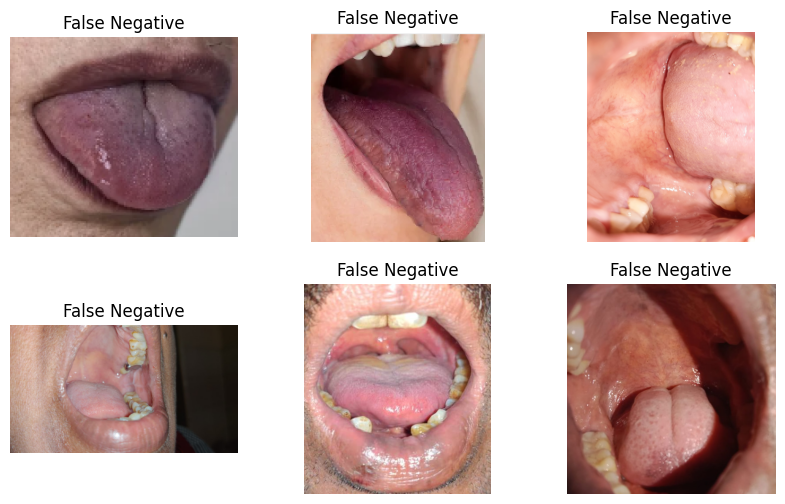

In [68]:
plt.figure(figsize=(10, 6))
for i, idx in enumerate(fn_indices[:6]):
    img_path = val_generator_eff.filepaths[idx]
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title("False Negative")
    plt.axis('off')
plt.show()

### CHECK 4 — Sanity test

In [69]:
import numpy as np

shuffled_labels = np.random.permutation(y_true_eff)

from sklearn.metrics import confusion_matrix

y_pred_test = (y_pred_prob_eff > 0.35).astype(int).ravel()
cm_shuffle = confusion_matrix(shuffled_labels, y_pred_test)

cm_shuffle

array([[52, 48],
       [44, 46]])

# **3 CNN**

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Model Building

In [71]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [73]:
history_cnn = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2026-01-28 19:01:13.251073: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 19:01:13.396891: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4986 - loss: 0.8928

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 447ms/step - accuracy: 0.4987 - loss: 0.8900 - val_accuracy: 0.5263 - val_loss: 0.7357
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.6513 - loss: 0.6504 - val_accuracy: 0.6474 - val_loss: 0.6172
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.7473 - loss: 0.5201 - val_accuracy: 0.7053 - val_loss: 0.5835
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 0.7373 - loss: 0.5527 - val_accuracy: 0.6842 - val_loss: 0.6166
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.7763 - loss: 0.5402 - val_accuracy: 0.6579 - val_loss: 0.5942
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.7625 - loss: 0.4717 - val_accuracy: 0.7211 - val_loss: 0.5429
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.8140 - loss: 0.4242 - val_accuracy: 0.7053 - val_loss: 0.5886
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.7762 - loss: 0.4657 - val_accuracy: 0.742

## Evaluation - CNN

In [74]:
val_generator.reset()
y_pred_prob_cnn = cnn_model.predict(val_generator)
y_true_cnn = val_generator.classes

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


In [75]:
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int).ravel()

print(y_pred_cnn.shape, y_true_cnn.shape)

(190,) (190,)


In [76]:
from sklearn.metrics import confusion_matrix

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
cm_cnn

array([[68, 32],
       [51, 39]])